In [1]:
!pip install tensorflow matplotlib
import tensorflow as tf
import os
import time
import numpy as np
import matplotlib.pyplot as plt
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [2]:
_URL = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz"
path_to_zip = tf.keras.utils.get_file(
    "facades.tar.gz",
    origin=_URL,
    extract=True
)
PATH = os.path.join(os.path.dirname(path_to_zip), "facades/")
print("Dataset Path:", PATH)

30168306/30168306 ━━━━━━━━━━━━━━━━━━━━ 55s 2us/step
Dataset Path: /root/.keras/datasets/facades/


In [4]:
import os
import tensorflow as tf
_URL = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz"

path_to_zip = tf.keras.utils.get_file(
    "facades.tar.gz",
    origin=_URL,
    extract=True
)
base_path = os.path.dirname(path_to_zip)
print("Base Path:", base_path)
print("Inside Base Path:")
print(os.listdir(base_path))

Base Path: /root/.keras/datasets
Inside Base Path:
['facades.tar.gz', 'facades_extracted']


In [3]:
import os
facades_path = "/root/.keras/datasets/facades_extracted"
print("Inside extracted folder:")
print(os.listdir(facades_path))

Inside extracted folder:
['facades']


In [5]:
PATH = "/root/.keras/datasets/facades_extracted/facades/"
print("Final PATH:", PATH)

Final PATH: /root/.keras/datasets/facades_extracted/facades/


In [6]:
train_path = PATH + "train/"
files = os.listdir(train_path)[:5]
print("Sample train images:", files)

Sample train images: ['162.jpg', '172.jpg', '398.jpg', '56.jpg', '166.jpg']


In [7]:
import tensorflow as tf
IMG_WIDTH = 256
IMG_HEIGHT = 256
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    target_image = image[:, w:, :]
    input_image = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)
    return input_image, target_image
def resize(input_image, target_image, height, width):
    input_image = tf.image.resize(input_image, [height, width])
    target_image = tf.image.resize(target_image, [height, width])
    return input_image, target_image
def normalize(input_image, target_image):
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    return input_image, target_image
def load_image_train(image_file):
    input_image, target_image = load(image_file)
    input_image, target_image = resize(
        input_image, target_image,
        IMG_HEIGHT, IMG_WIDTH
    )
    input_image, target_image = normalize(
        input_image, target_image
    )
    return input_image, target_image
train_path = PATH + "train/"

files = tf.io.gfile.listdir(train_path)

sample_image = train_path + files[0]

inp, tar = load_image_train(sample_image)

print("Input shape:", inp.shape)
print("Target shape:", tar.shape)


Input shape: (256, 256, 3)
Target shape: (256, 256, 3)


In [8]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
train_dataset = tf.data.Dataset.list_files(PATH + "train/*.jpg")
train_dataset = train_dataset.map(
    load_image_train,
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
print("Dataset pipeline created successfully.")

Dataset pipeline created successfully.


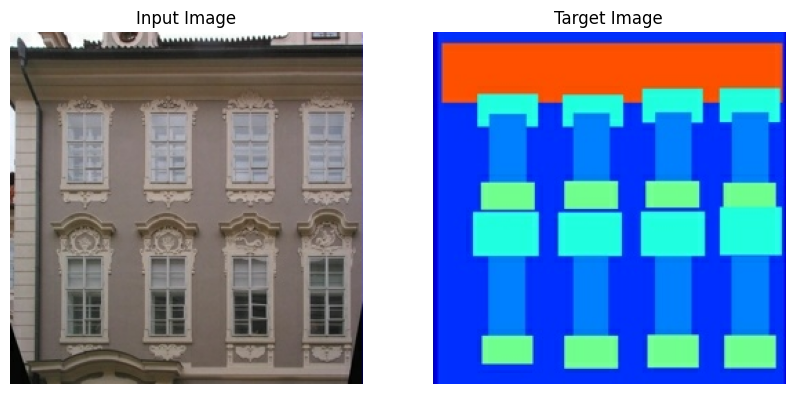

In [9]:
for input_image, target_image in train_dataset.take(1):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Input Image")
    plt.imshow((input_image[0] + 1) / 2)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.title("Target Image")
    plt.imshow((target_image[0] + 1) / 2)
    plt.axis("off")

In [10]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters, size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result


In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [12]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        3, 4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='tanh'
    )
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


In [13]:
generator = Generator()
print("Generator created successfully.")

Generator created successfully.


In [14]:
generator.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [15]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(
        512, 4,
        strides=1,
        kernel_initializer=initializer,
        use_bias=False
    )(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(
        1, 4,
        strides=1,
        kernel_initializer=initializer
    )(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [16]:
discriminator = Discriminator()
print("Discriminator created successfully.")

Discriminator created successfully.


In [17]:
discriminator.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      6,144 │ concatenate_7[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │    525,312 │ sequential_16[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_17[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_11[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [18]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, generated_output):
    real_loss = loss_object(
        tf.ones_like(real_output),
        real_output
    )
    generated_loss = loss_object(
        tf.zeros_like(generated_output),
        generated_output
    )
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss
LAMBDA = 100
def generator_loss(disc_generated_output,
                   gen_output,
                   target):
    gan_loss = loss_object(
        tf.ones_like(disc_generated_output),
        disc_generated_output
    )
    l1_loss = tf.reduce_mean(
        tf.abs(target - gen_output)
    )
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss
for inp, tar in train_dataset.take(1):
    gen_output = generator(inp, training=False)
    disc_real = discriminator([inp, tar], training=False)
    disc_fake = discriminator([inp, gen_output], training=False)
    d_loss = discriminator_loss(disc_real, disc_fake)
    g_loss, gan_loss, l1_loss = generator_loss(
        disc_fake, gen_output, tar
    )
    print("Discriminator Loss:", d_loss.numpy())
    print("Generator Loss:", g_loss.numpy())

Discriminator Loss: 1.3924608
Generator Loss: 77.08832


In [19]:
generator_optimizer = tf.keras.optimizers.Adam(
    2e-4, beta_1=0.5
)
discriminator_optimizer = tf.keras.optimizers.Adam(
    2e-4, beta_1=0.5
)
print("Optimizers created successfully.")

Optimizers created successfully.


In [20]:
@tf.function
def train_step(input_image, target):

    with tf.GradientTape() as gen_tape, \
         tf.GradientTape() as disc_tape:

        gen_output = generator(
            input_image,
            training=True
        )

        disc_real_output = discriminator(
            [input_image, target],
            training=True
        )

        disc_generated_output = discriminator(
            [input_image, gen_output],
            training=True
        )

        gen_total_loss, gen_gan_loss, gen_l1_loss = \
            generator_loss(
                disc_generated_output,
                gen_output,
                target
            )

        disc_loss = discriminator_loss(
            disc_real_output,
            disc_generated_output
        )

    generator_gradients = gen_tape.gradient(
        gen_total_loss,
        generator.trainable_variables
    )

    discriminator_gradients = disc_tape.gradient(
        disc_loss,
        discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(generator_gradients,
            generator.trainable_variables)
    )

    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients,
            discriminator.trainable_variables)
    )


    return gen_total_loss, disc_loss


In [21]:
import matplotlib.pyplot as plt

def generate_images(model, test_input, target):

    prediction = model(
        test_input,
        training=True
    )

    plt.figure(figsize=(12,4))

    display_list = [
        test_input[0],
        target[0],
        prediction[0]
    ]

    title = [
        'Input Image',
        'Ground Truth',
        'Generated Image'
    ]

    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')

    plt.show()


In [22]:
EPOCHS = 50

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    for input_image, target in train_dataset:
        g_loss, d_loss = train_step(
            input_image,
            target
        )

    print(
        f"Generator Loss: {g_loss.numpy():.4f} | "
        f"Discriminator Loss: {d_loss.numpy():.4f}"
    )

    for inp, tar in train_dataset.take(1):
        generate_images(generator, inp, tar)


Output hidden; open in https://colab.research.google.com to view.

In [23]:
def generate_images(model, test_input, target):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(12,4))
    display_list = [
        test_input[0],
        target[0],
        prediction[0]
    ]
    title = [
        'Input Image',
        'Ground Truth',
        'Generated Image'
    ]
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()


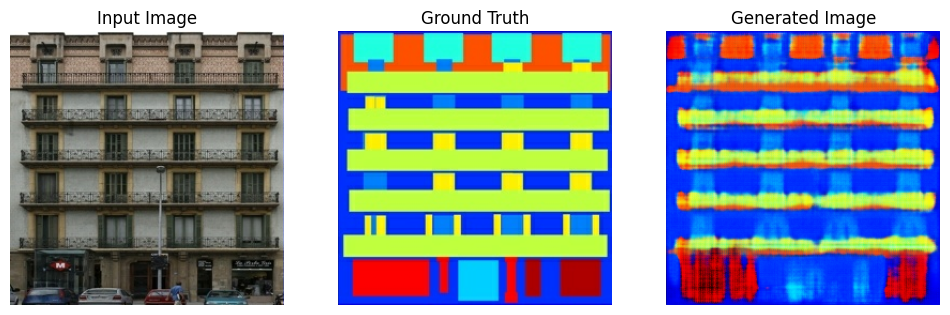

In [24]:
for inp, tar in train_dataset.take(1):
    generate_images(generator, inp, tar)